In [1]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lecilab_behavior_analysis.df_transforms as dft
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import statsmodels.api as sm
%load_ext autoreload
%autoreload 2


In [2]:
import warnings
warnings.filterwarnings('ignore')


single mouse

In [3]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)

['auditory_escape_data', 'cate_task_data', 'COT_cannula_data', 'COT_test_data', 'visual_and_COT_data']


In [5]:
project = "visual_and_COT_data"

In [7]:
# see the available animals
animals = utils.get_animals_in_project(project)
print(animals)
# download the data for a specific animal
mouse = "ACV007"
local_path = Path(utils.get_outpath()) / Path(project) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_cluster_data(
    project_name=project,
    file_path="sessions/{}/{}.csv".format(mouse, mouse),
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'prueba', 'punish_test', 'test', 'test2']
receiving incremental file list

sent 27 bytes  received 78 bytes  42.00 bytes/sec
total size is 501,171,573  speedup is 4,773,062.60


In [8]:
# reduce the dataset to the psychometric version of the task
# Otherwise, we would include a lot of "easy" trials that would bias the fit
df_test = df[df["current_training_stage"] == "TwoAFC_visual_hard"]

psychometric curve 

In [11]:
df_test = dft.analyze_df(df_test)

In [13]:
df_test.columns

Index(['session', 'date', 'trial', 'subject', 'task', 'system_name',
       'run_mode', 'Port1In', 'Port1Out', 'Port2In', 'Port2Out', 'Port3In',
       'Port3Out', 'STATE_auto_reward_state_left_END',
       'STATE_auto_reward_state_left_START', 'STATE_hold_center_port_END',
       'STATE_hold_center_port_START', 'STATE_hold_while_stimulus_END',
       'STATE_hold_while_stimulus_START', 'STATE_iti_END', 'STATE_iti_START',
       'STATE_punish_state_END', 'STATE_punish_state_START',
       'STATE_ready_to_initiate_END', 'STATE_ready_to_initiate_START',
       'STATE_reward_state_END', 'STATE_reward_state_START',
       'STATE_reward_state_left_END', 'STATE_reward_state_left_START',
       'STATE_reward_state_right_END', 'STATE_reward_state_right_START',
       'STATE_start_of_trial_END', 'STATE_start_of_trial_START',
       'STATE_stimulus_state_END', 'STATE_stimulus_state_START', 'TRIAL_END',
       'TRIAL_START', 'Tup', 'auditory_real_statistics', 'auditory_stimulus',
       'correct',

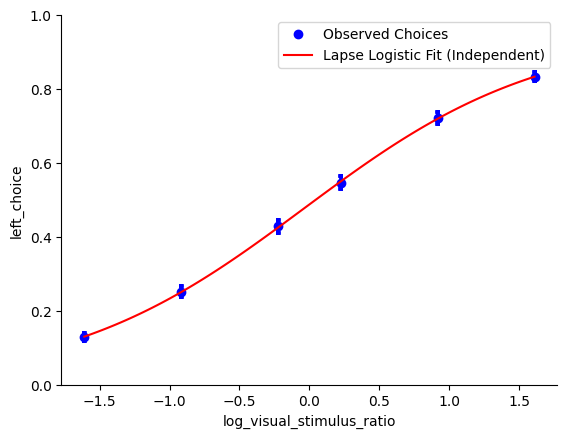

In [14]:
df_test = dft.get_performance_by_difficulty_ratio(df_test)
df_test = dft.get_left_choice(df_test)
plots.psychometric_plot(df_test, x = 'visual_stimulus_ratio', y = 'left_choice')
plt.show()

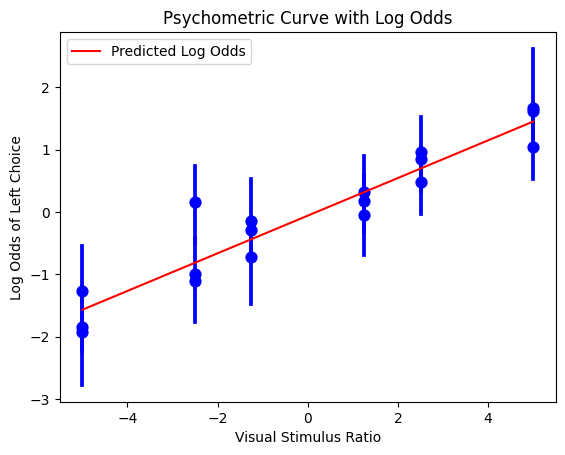

In [15]:
# Example plot with log-scaled y-axis
sns.pointplot(
    x='visual_stimulus_ratio',
    y='left_choice',
    data=df_test,
    estimator=lambda x: np.log(np.mean(x) / (1 - np.mean(x))),  # Log odds transformation
    color='blue',
    markers='o',
    errorbar=("ci", 95),
    native_scale=True,
    linestyles='',
)

X = df_test['visual_stimulus_ratio'].unique()
log_odds = []
for x in X:
    p = df_test[df_test['visual_stimulus_ratio'] == x]['left_choice'].mean()
    log_odds.append(np.log(p / (1 - p)))

# fit a simple line to the points
model = np.polyfit(X, log_odds, 1)
xs = np.linspace(df_test['visual_stimulus_ratio'].min(), df_test['visual_stimulus_ratio'].max(), 100).reshape(-1, 1)
predicted_log_odds = model[0] * xs + model[1]

plt.plot(xs, predicted_log_odds, color='red', label='Predicted Log Odds')
plt.legend()

plt.xlabel("Visual Stimulus Ratio")
plt.ylabel("Log Odds of Left Choice")
plt.title("Psychometric Curve with Log Odds")

plt.show()

GLM comparation

In [ ]:
utils.column_checker(df_test, required_columns={x for x in parameters_for_fit})

In [ ]:
import statsmodels.api as sm

parameters_for_fit = ['visual_stimulus_ratio',
                      'previous_port_before_stimulus_numeric',
                      'interaction_term',
                      'previous_choice_left_correct',
                      'previous_choice_right_wrong',
                      'previous_choice_left', 
                      'interaction_term_brightness'
                    ]
variable_for_prediction = 'left_choice'

# drop NaN values if any
df_for_fit = df_test.dropna(subset=parameters_for_fit + [variable_for_prediction])
df_for_fit = df_for_fit[parameters_for_fit].astype(int)

# Prepare the independent variables
X_multi = df_for_fit[parameters_for_fit].values
X_multi_const = sm.add_constant(X_multi)
y = df_for_fit[variable_for_prediction].values.astype(int)

# Fit the logistic regression model with multiple regressors
logit_model_multi = sm.Logit(y, X_multi_const).fit()

# Display the summary, which includes p-values for all regressors
print(logit_model_multi.summary(xname= ["intercept"] + parameters_for_fit))

In [ ]:
#remove the [] of parameters_for_fit
parameters_ = [f"'{param}'" for param in parameters_for_fit]
parameters_

calculate the "evidences" and the choices

In [ ]:
df_test['visual_stimulus_ratio'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[0] / eval(x)[1]))
# transform it to a log value, preserving the negative sign
df_test['visual_stimulus_ratio'] = df_test['visual_stimulus_ratio'].apply(lambda x: np.log(x))
# reduce the decimal places to 4, so it is easier to read
df_test['visual_stimulus_ratio'] = df_test['visual_stimulus_ratio'].apply(lambda x: round(x, 4))
# This was good in order to make the fit work for both left and right choices!
df_test['visual_stimulus_ratio'] = df_test.apply(
    lambda row: row['visual_stimulus_ratio'] if row['correct_side'] == 'left' else -row['visual_stimulus_ratio'],
    axis=1
)
df_test['visual_stimulus_diff'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[0] - eval(x)[1]))
df_test['visual_stimulus_diff'] = df_test.apply(
    lambda row: row['visual_stimulus_diff'] if row['correct_side'] == 'left' else -row['visual_stimulus_diff'],
    axis=1
)

# !!!!! This introduces a bug!! What would happen on the trials where the mouse has to go right? Which value would be used then?
# df_test['left_choice'] = np.where((df_test['correct_side'] == 'left') & (df_test['correct'] == True), 1, 0)

# What you want is a value that goes from 0 to 1, indicating the probability of a left choice.
# For this fits, we really don't care about the correct side, we just want to know if the mouse chose left or right.

# I realized that the way I was plotting this before was using the performance of the mouse and the trials difficulty,
# in order to infer back the probability of a left choice. But we can actually use something simpler and less confusing:

# I had already created a function in the df_transforms module, to get the first choice of a mouse so we can use it here
df_test = dft.add_mouse_first_choice(df_test)
# This creates the column "first_choice" that indicates "left" or "right" for each trial.

# Now we can transform this to 0 and 1, where 0 is right and 1 is left
df_test['left_choice'] = df_test['first_choice'].apply(lambda x: 1 if x == 'left' else 0)

# By the way I am naming columns weirdly, just so you can play around with the different solutions and see how they work.
# Once we have what we need, we should clean up the code and use more meaningful names.

In [ ]:
def get_evidence_ratio(df):
    df['visual_stimulus_ratio'] = df['visual_stimulus'].apply(lambda x: abs(eval(x)[0] / eval(x)[1]))
    # transform it to a log value, preserving the negative sign
    df['visual_stimulus_ratio'] = df['visual_stimulus_ratio'].apply(lambda x: np.log(x))
    # reduce the decimal places to 4, so it is easier to read
    df['visual_stimulus_ratio'] = df['visual_stimulus_ratio'].apply(lambda x: round(x, 4))
    # This was good in order to make the fit work for both left and right choices!
    df['visual_stimulus_ratio'] = df.apply(
        lambda row: row['visual_stimulus_ratio'] if row['correct_side'] == 'left' else -row['visual_stimulus_ratio'],
        axis=1
    )
    return df

def get_left_choice(df):
    df = dft.add_mouse_first_choice(df)
    df['left_choice'] = df['first_choice'].apply(lambda x: 1 if x == 'left' else 0)
    return df

df_test = get_evidence_ratio(df_test)
df_test = get_left_choice(df_test)

In [ ]:
# Now we can fit the data and visualize the results
X = df_test['visual_stimulus_ratio'].values.reshape(-1, 1)
y = df_test['left_choice'].values.astype(int)
model = LogisticRegression()
model.fit(X, y)

# Now we have a model that predicts the probability of a left choice based on ANY visual stimulus ratio (xs).
# For plotting, we can generate a range of values for the visual stimulus ratio
import numpy as np
xs = np.linspace(df_test['visual_stimulus_ratio'].min(), df_test['visual_stimulus_ratio'].max(), 100).reshape(-1, 1)
y_prob = model.predict_proba(xs)[:, 1]

# Plot the actual choices of the mouse
fig, ax = plt.subplots(figsize=(5, 5))
sns.pointplot(
    x='visual_stimulus_ratio',
    y='left_choice',
    data=df_test,
    estimator=lambda x: np.mean(x),
    color='blue',
    markers='o',
    errorbar=("ci", 95),
    ax=ax,
    label='Observed Choices',
    native_scale= True,
    linestyles='',
)

# overlay the fitted logistic regression curve
ax.plot(xs, y_prob, color='red', label='Logistic Regression Fit')
ax.set_xlabel("Visual Stimulus ratio")
ax.set_ylabel("Probability of Left Choice")
ax.set_ylim(0, 1)
plt.title("Psychometric Curve")
plt.legend()
plt.show()



In [ ]:
# testing a model with lapses
from scipy.optimize import minimize
import numpy as np

# Define the lapse logistic function with independent lapses for left and right
def lapse_logistic_independent(params, x, y):
    lapse_left, lapse_right, beta, x0 = params
    # Ensure lapse rates are within [0, 0.5]
    lapse_left = np.clip(lapse_left, 0, 0.5)
    lapse_right = np.clip(lapse_right, 0, 0.5)
    # Predicted probabilities
    p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (x - x0)))
    # Negative log-likelihood
    nll = -np.sum(y * np.log(p_left) + (1 - y) * np.log(1 - p_left))
    return nll

# Initial parameter guesses: [lapse_left, lapse_right, beta, x0]
initial_params = [0.05, 0.05, 1, 0]

# Fit the model
x = df_test['visual_stimulus_ratio'].values
y = df_test['left_choice'].values
result = minimize(
    lapse_logistic_independent,
    initial_params,
    args=(x, y),
    bounds=[(0, 0.5), (0, 0.5), (None, None), (None, None)]
)

# Extract fitted parameters
lapse_left, lapse_right, beta, x0 = result.x
print(f"Lapse Left: {lapse_left}, Lapse Right: {lapse_right}, Slope (Beta): {beta}, PSE (x0): {x0}")

# Generate predictions
xs = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (xs - x0)))

# Plot the fitted curve
fig, ax = plt.subplots(figsize=(5, 5))
sns.pointplot(
    x='visual_stimulus_ratio',
    y='left_choice',
    data=df_test,
    estimator=lambda x: np.mean(x),
    color='blue',
    markers='o',
    errorbar=("ci", 95),
    ax=ax,
    label='Observed Choices',
    native_scale=True,
    linestyles='',
)
ax.plot(xs, p_left, color='red', label='Lapse Logistic Fit (Independent)')
ax.set_xlabel("Visual Stimulus ratio")
ax.set_ylabel("Probability of Left Choice")
ax.set_ylim(0, 1)
plt.title("Psychometric Curve with Independent Lapses")
plt.legend()
plt.show()

the following cell can be use to evaluate the model. It will be useful when comparing different models

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.optimize import minimize
import numpy as np

# Define the lapse logistic function with independent lapses for left and right
def lapse_logistic_independent(params, x, y):
    lapse_left, lapse_right, beta, x0 = params
    # Ensure lapse rates are within [0, 0.5]
    lapse_left = np.clip(lapse_left, 0, 0.5)
    lapse_right = np.clip(lapse_right, 0, 0.5)
    # Predicted probabilities
    p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (x - x0)))
    # Negative log-likelihood
    nll = -np.sum(y * np.log(p_left) + (1 - y) * np.log(1 - p_left))
    return nll

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
log_losses = []

# Perform cross-validation
for train_index, test_index in kf.split(df_test):
    # Split the data
    x_train, x_test = df_test['visual_stimulus_ratio'].values[train_index], df_test['visual_stimulus_ratio'].values[test_index]
    y_train, y_test = df_test['left_choice'].values[train_index], df_test['left_choice'].values[test_index]
    
    # Initial parameter guesses: [lapse_left, lapse_right, beta, x0]
    initial_params = [0.05, 0.05, 1, 0]
    
    # Fit the model on the training data
    result = minimize(
        lapse_logistic_independent,
        initial_params,
        args=(x_train, y_train),
        bounds=[(0, 0.5), (0, 0.5), (None, None), (None, None)]
    )
    
    # Extract fitted parameters
    lapse_left, lapse_right, beta, x0 = result.x
    
    # Generate predictions on the test data
    p_left_test = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (x_test - x0)))
    
    # Calculate log loss for the test data
    loss = log_loss(y_test, p_left_test)
    log_losses.append(loss)

# Print cross-validation results
print(f"Cross-Validation Log Losses: {log_losses}")
print(f"Mean Log Loss: {np.mean(log_losses)}")
print(f"Standard ratio of Log Loss: {np.std(log_losses)}")

In [ ]:
# independent lapses model applied to the difference

# Initial parameter guesses: [lapse_left, lapse_right, beta, x0]
initial_params = [0.05, 0.05, 1, 0]

# Fit the model
x = df_test['visual_stimulus_diff'].values
y = df_test['left_choice'].values
result = minimize(
    lapse_logistic_independent,
    initial_params,
    args=(x, y),
    bounds=[(0, 0.5), (0, 0.5), (None, None), (None, None)]
)

# Extract fitted parameters
lapse_left, lapse_right, beta, x0 = result.x
print(f"Lapse Left: {lapse_left}, Lapse Right: {lapse_right}, Slope (Beta): {beta}, PSE (x0): {x0}")

# Generate predictions
xs = np.linspace(df_test['visual_stimulus_diff'].min(), df_test['visual_stimulus_diff'].max(), 100)
p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (xs - x0)))

# Plot the fitted curve
fig, ax = plt.subplots(figsize=(5, 5))
# bin the visual stimulus difference for better visualization
df_test["visual_stimulus_diff_binned"] = df_test['visual_stimulus_diff'] // 0.1 / 10
sns.pointplot(
    x='visual_stimulus_diff_binned',
    y='left_choice',
    data=df_test,
    estimator=lambda x: np.mean(x),
    color='blue',
    markers='o',
    errorbar=("ci", 95),
    ax=ax,
    label='Observed Choices',
    native_scale=True,
    linestyles='',
)
ax.plot(xs, p_left, color='red', label='Lapse Logistic Fit')
ax.set_xlabel("Visual Stimulus Difference")
ax.set_ylabel("Probability of Left Choice")
plt.title("Psychometric Curve with Independent Lapses")
plt.legend()
plt.show()

weight and stats for the different predictors:
- visual stimulus ratio (you call it deviation)
- visual stimulus diff. Nuo: change to "total intensity on left port"
- port where the animal is coming from
- interactions
- Nuo: add another regressor: the previous correct choice

We can play around with this things

In [ ]:
# get what the animal is doing, if it is alternating or repeating to the left or to the right
df_test = dft.add_mouse_first_choice(df_test)
df_test = dft.add_mouse_last_choice(df_test)
df_test = dft.add_port_where_animal_comes_from(df_test)
# turn the column "previous_port_before_stimulus" into a numeric value, where 0 is right and 1 is left
df_test['previous_port_before_stimulus_numeric'] = df_test['previous_port_before_stimulus'].apply(
    lambda x: 1 if x == 'left' else 0 if x == 'right' else np.nan
)
# turn the column "roa_choice" into a numeric value, where 0 is alternate and 1 is repeat
df_test['roa_choice_numeric'] = df_test['roa_choice'].apply(
    lambda x: 1 if x == 'repeat' else 0 if x == 'alternate' else np.nan
)

In [ ]:
# Add an interaction term between visual_stimulus_ratio and visual_stimulus_diff
def interaction_calc(row):
    is_left = 1 if row['correct_side'] == 'left' else -1
    return row['visual_stimulus_ratio'] * row['visual_stimulus_diff'] * is_left

df_test['interaction_term'] = df_test.apply(interaction_calc, axis=1)

In [ ]:
# get the intensity of left stimulus for each trial
import ast
df_test['left_ilumi'] = df_test.apply(
    lambda row: ast.literal_eval(row['visual_stimulus'])[0] if row['correct_side'] == 'left' else ast.literal_eval(row['visual_stimulus'])[1],
    axis=1
)

In [ ]:
def interaction_calc_brightness(row):
    is_left = 1 if row['correct_side'] == 'left' else -1
    return row['left_ilumi'] * row['visual_stimulus_ratio'] * is_left
df_test['interaction_term_brightness'] = df_test.apply(interaction_calc_brightness, axis=1)

In [ ]:
# Add the previous choice is left and correct as 1, or 0, remain NaN
if "last_choice" not in df_test.columns:
    df_test = dft.add_mouse_last_choice(df_test)
df_test['previous_choice_left_correct'] = np.nan
df_test['previous_choice_left_correct'] = df_test['previous_choice_left_correct'].astype(object)
for mouse in df_test['subject'].unique():
    for session in df_test[df_test.subject == mouse]['session'].unique():
        df_mouse_session = df_test[np.logical_and(df_test['subject'] == mouse, df_test['session'] == session)]
        df_mouse_session['last_choice_in_previous'] = df_mouse_session['last_choice'].shift(1, fill_value=np.nan)
        df_mouse_session['correct_in_previous'] = df_mouse_session['correct'].shift(1, fill_value=np.nan)

        series_to_append = np.where(
            df_mouse_session['last_choice_in_previous'].isna() | df_mouse_session['correct_in_previous'].isna(),
            None,
            ((df_mouse_session['last_choice_in_previous'] == 'left') & (df_mouse_session['correct_in_previous'] == True)).astype(int)
        )
        df_test.loc[df_mouse_session.index, 'previous_choice_left_correct'] = series_to_append


In [ ]:
# Add the previous choice is right and wrong as 1, or 0, remain NaN
if "last_choice" not in df_test.columns:
    df_test = dft.add_mouse_last_choice(df_test)
df_test['previous_choice_right_wrong'] = np.nan
df_test['previous_choice_right_wrong'] = df_test['previous_choice_right_wrong'].astype(object)
for mouse in df_test['subject'].unique():
    for session in df_test[df_test.subject == mouse]['session'].unique():
        df_mouse_session = df_test[np.logical_and(df_test['subject'] == mouse, df_test['session'] == session)]
        df_mouse_session['last_choice_in_previous'] = df_mouse_session['last_choice'].shift(1, fill_value=np.nan)
        df_mouse_session['wrong_in_previous'] = df_mouse_session['correct'].shift(1, fill_value=np.nan)

        series_to_append = np.where(
            df_mouse_session['last_choice_in_previous'].isna() | df_mouse_session['wrong_in_previous'].isna(),
            None,
            ((df_mouse_session['last_choice_in_previous'] == 'right') & (df_mouse_session['wrong_in_previous'] == False)).astype(int)
        )
        df_test.loc[df_mouse_session.index, 'previous_choice_right_wrong'] = series_to_append


In [ ]:
for mouse in df_test['subject'].unique():
    for session in df_test[df_test.subject == mouse]['session'].unique():
        df_mouse_session = df_test[np.logical_and(df_test['subject'] == mouse, df_test['session'] == session)]
        df_mouse_session['last_choice_in_previous'] = df_mouse_session['last_choice'].shift(1, fill_value=np.nan)

        series_to_append = np.where(
            df_mouse_session['last_choice_in_previous'].isna(),
            None,
            (df_mouse_session['last_choice_in_previous'] == 'left').astype(int)
        )
        df_test.loc[df_mouse_session.index, 'previous_choice_left'] = series_to_append


In [ ]:
import statsmodels.api as sm

parameters_for_fit = ['visual_stimulus_ratio',
                      'previous_port_before_stimulus_numeric',
                      'interaction_term',
                      'previous_choice_left_correct',
                      'previous_choice_right_wrong',
                      'previous_choice_left', 
                      'interaction_term_brightness'
                    ]
variable_for_prediction = 'left_choice'

# drop NaN values if any
df_for_fit = df_test.dropna(subset=parameters_for_fit + [variable_for_prediction])
df_for_fit = df_for_fit[parameters_for_fit].astype(int)

# Prepare the independent variables
X_multi = df_for_fit[parameters_for_fit].values
X_multi_const = sm.add_constant(X_multi)
y = df_for_fit[variable_for_prediction].values.astype(int)

# Fit the logistic regression model with multiple regressors
logit_model_multi = sm.Logit(y, X_multi_const).fit()

# Display the summary, which includes p-values for all regressors
print(logit_model_multi.summary(xname= ["intercept"] + parameters_for_fit))

In [ ]:
from lecilab_behavior_analysis import plots


correct choice as output

In [ ]:
df_new_for_fit = dft.parameters_for_fit(df_test)
results = utils.logi_model_fit(df_new_for_fit, X = ['visual_stimulus_ratio',
                                                    'wrong_bright', 
                                                    # 'wrong_bright_zscore',
                                                    'previous_same_choice_correct_numeric', 
                                                    # 'previous_diff_choice_wrong_numeric', 
                                                    'previous_same_choice_numeric', 
                                                    'previous_correct_numeric'
                                                    ], y = 'correct_numeric')
print(results) 

In [ ]:
if "last_choice" not in df_test.columns:
    df_test = dft.add_mouse_last_choice(df_test)
for mouse in df_test['subject'].unique():
    for session in df_test[df_test.subject == mouse]['session'].unique():
        df_mouse_session = df_test[np.logical_and(df_test['subject'] == mouse, df_test['session'] == session)]
        df_mouse_session['last_choice_in_previous'] = df_mouse_session['last_choice'].shift(1, fill_value=np.nan)
        df_mouse_session['correct_in_previous'] = df_mouse_session['correct'].shift(1, fill_value=np.nan)
        
        series_to_append = np.where(
            df_mouse_session['last_choice_in_previous'].isna() | df_mouse_session['correct_in_previous'].isna(),
            None,
            (((df_mouse_session['last_choice_in_previous'] == 'left') & (df_mouse_session['left_choice'] == 1) & (df_mouse_session['correct_in_previous'] == True)) 
             | ((df_mouse_session['last_choice_in_previous'] == 'right') & (df_mouse_session['left_choice'] == 0) & (df_mouse_session['correct_in_previous'] == True))
            ).astype(int)
        )
        df_test.loc[df_mouse_session.index, 'same_choice_correctPre'] = series_to_append

        series_to_append = np.where(
            df_mouse_session['last_choice_in_previous'].isna() | df_mouse_session['correct_in_previous'].isna(),
            None,
            (((df_mouse_session['last_choice_in_previous'] == 'left') & (df_mouse_session['left_choice'] == 0) & (df_mouse_session['correct_in_previous'] == False)) 
             | ((df_mouse_session['last_choice_in_previous'] == 'right') & (df_mouse_session['left_choice'] == 1) & (df_mouse_session['correct_in_previous'] == False))
            ).astype(int)
        )
        df_test.loc[df_mouse_session.index, 'diff_choice_wrongPre'] = series_to_append

In [ ]:
df_test['wrong_bright'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[1]))
df_test['correct_bright'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[0]))
df_test['bright_relative_correct_1'] = df_test['correct_bright'] / (df_test['wrong_bright'] + df_test['correct_bright'])
df_test['bright_relative_correct_2'] = df_test['correct_bright'] / (df_test['wrong_bright'] - df_test['correct_bright'])

df_test.dropna(subset=['same_choice_correctPre'], inplace=True)
df_test['same_choice_correctPre'] = df_test['same_choice_correctPre'].astype(int)

df_test.dropna(subset=['diff_choice_wrongPre'], inplace=True)
df_test['diff_choice_wrongPre'] = df_test['diff_choice_wrongPre'].astype(int)

In [ ]:
df_test['correct_numeric'] = df_test['correct'].astype(int)

In [ ]:
X = np.array([get_timebin_evidence(eval(t)) for t in df_auditory['auditory_stimulus']])
df_aud_fit = dft.parameters_for_fit(df_auditory)
y = df_aud_fit['first_choice_numeric']
X_model = sm.add_constant(X) 
glm = sm.Logit(y, X_model).fit()
plt.plot(glm.params[1:])

In [ ]:
df_auditory = dft.get_performance_by_difficulty_ratio(df_auditory)
plots.psychometric_plot(df_auditory, x = 'total_evidence_strength', y = 'first_choice_numeric', valueType = 'continue')

In [ ]:
df_auditory_fit = dft.parameters_for_fit(df_auditory)

In [ ]:
results, _ = utils.logi_model_fit(df_auditory_fit, X = ['total_percentage_of_tones_left',
                      'number_of_tones_left',
                      'percentage_of_timebins_with_evidence_left', 
                      'total_evidence_strength', 
                      'amplitude_strength'
                          ], y = 'first_choice_numeric')
print(results)

In [ ]:
df_test.dropna(subset=['same_choice_previous'], inplace=True)
df_test['same_choice_previous'] = df_test['same_choice_previous'].astype(int)
df_test.dropna(subset=['previous_correct'], inplace=True)
df_test['previous_correct'] = df_test['previous_correct'].astype(int)

In [ ]:
if "last_choice" not in df_test.columns:
    df_test = dft.add_mouse_last_choice(df_test)
for mouse in df_test['subject'].unique():
    for session in df_test[df_test.subject == mouse]['session'].unique():
        df_mouse_session = df_test[np.logical_and(df_test['subject'] == mouse, df_test['session'] == session)]
        df_mouse_session['last_choice_in_previous'] = df_mouse_session['last_choice'].shift(1, fill_value=np.nan)
        df_mouse_session['correct_in_previous'] = df_mouse_session['correct'].shift(1, fill_value=np.nan)
        
        # Define conditions for the 4 groups
        conditions = [
            ((df_mouse_session['last_choice_in_previous'] == 'left') & (df_mouse_session['left_choice'] == 1) & (df_mouse_session['correct_in_previous'] == True)) | ((df_mouse_session['last_choice_in_previous'] == 'right') & (df_mouse_session['left_choice'] == 0) & (df_mouse_session['correct_in_previous'] == True)),
            ((df_mouse_session['last_choice_in_previous'] == 'left') & (df_mouse_session['left_choice'] == 1) & (df_mouse_session['correct_in_previous'] == False)) | ((df_mouse_session['last_choice_in_previous'] == 'right') & (df_mouse_session['left_choice'] == 0) & (df_mouse_session['correct_in_previous'] == False)),
            ((df_mouse_session['last_choice_in_previous'] == 'left') & (df_mouse_session['left_choice'] == 0) & (df_mouse_session['correct_in_previous'] == True)) | ((df_mouse_session['last_choice_in_previous'] == 'right') & (df_mouse_session['left_choice'] == 1) & (df_mouse_session['correct_in_previous'] == True)),
            ((df_mouse_session['last_choice_in_previous'] == 'left') & (df_mouse_session['left_choice'] == 0) & (df_mouse_session['correct_in_previous'] == False)) | ((df_mouse_session['last_choice_in_previous'] == 'right') & (df_mouse_session['left_choice'] == 1) & (df_mouse_session['correct_in_previous'] == False)),
        ]

        # Corresponding values
        values = [2, -2, 1, -1] # same choice correct, same choice wrong, different choice correct, different choice wrong

        # Assign group values, set to None if any isna
        series_to_append = np.select(
            condlist=conditions,
            choicelist=values,
            default=None
        )
        series_to_append = np.where(
            df_mouse_session['last_choice_in_previous'].isna() | df_mouse_session['correct_in_previous'].isna() | df_mouse_session['left_choice'].isna(),
            None,
            series_to_append
        )
        df_test.loc[df_mouse_session.index, 'previous_choice_same_correct'] = series_to_append


In [ ]:
df_test.dropna(subset=['previous_choice_same_correct'], inplace=True)
df_test['previous_choice_same_correct'] = df_test['previous_choice_same_correct'].astype(int)

In [ ]:
df_test['wrong_bright_zscore'] = df_test.groupby('abs_visual_stimulus_ratio')['wrong_bright'].transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
parameters_for_fit = ['abs_visual_stimulus_ratio',
                      'wrong_bright', 
                      # 'wrong_bright_zscore',
                      # 'bright_relative_correct_1',
                      # 'bright_relative_correct_2',
                      # 'same_choice_correctPre', 
                      # 'diff_choice_wrongPre', 
                      'same_choice_previous', 
                      'previous_correct', 
                      # 'previous_choice_same_correct',
                    ]
variable_for_prediction = 'correct_numeric'

# drop NaN values if any
df_for_fit = df_test.dropna(subset=parameters_for_fit + [variable_for_prediction])
# Prepare the independent variables
X_multi = df_for_fit[parameters_for_fit].values
X_multi_const = sm.add_constant(X_multi)
y = df_for_fit[variable_for_prediction].values.astype(int) 
# Fit the logistic regression model with multiple regressors
logit_model_multi = sm.Logit(y, X_multi_const).fit()
# Display the summary, which includes p-values for all regressors
print(logit_model_multi.summary(xname= ["intercept"] + parameters_for_fit))

Correct wrong psychometric curve

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_test[df_test['previous_choice'] == 'left'].groupby('previous_correct'), ['red', 'green']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[0],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )

for i, linecolor in zip(df_test[df_test['previous_choice'] == 'right'].groupby('previous_correct'), ['red', 'green']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[1],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )
ax[0].legend()
ax[0].set_title("Left Choice Previous")
ax[1].legend()
ax[1].set_title("Right Choice Previous")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_test[df_test['previous_correct'] == True].groupby('previous_choice'), ['gold', 'lightskyblue']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[0],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )

for i, linecolor in zip(df_test[df_test['previous_correct'] == False].groupby('previous_choice'), ['gold', 'lightskyblue']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[1],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )
ax[0].legend()
ax[0].set_title("Correct Choice Previous")
ax[1].legend()
ax[1].set_title("Incorrect Choice Previous")

Matrix format

In [21]:
# run this if you want to pull data from several animals
animals = ["ACV001", "ACV002", "ACV003", "ACV004", "ACV005", "ACV006", "ACV007", "ACV008", "ACV009", "ACV010"]
df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(project) / Path("sessions") / Path(mouse)
    # load the data
    df_list.append(pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";"))
df = pd.concat(df_list, ignore_index=True)

df_test = df[df["current_training_stage"] == "TwoAFC_visual_hard"]
df_test = dft.analyze_df(df_test)

In [23]:
df_test = dft.get_performance_by_difficulty_ratio(df_test)
df_test = dft.get_left_choice(df_test)

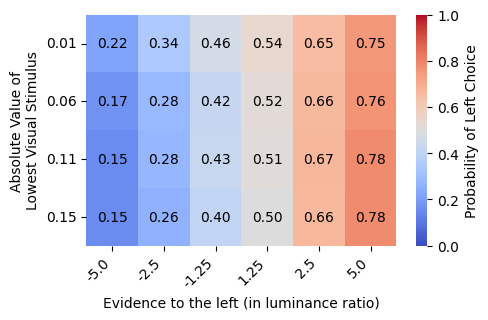

In [42]:
# let's use the absolute value of the lowest visual stimulus as a proxy for the brightness of the visual stimulus
df_test['visual_stimulus_lowest'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[0]) if eval(x)[0] < eval(x)[1] else abs(eval(x)[1]))
# visual stimulus ratio to only two decimal places
df_test['visual_stimulus_ratio'] = df_test['visual_stimulus_ratio'].apply(lambda x: round(x, 2))
# create 10 bins for the absolute value of the lowest visual stimulus
min_value = df_test['visual_stimulus_lowest'].min()
max_value = df_test['visual_stimulus_lowest'].max()
bins = np.linspace(min_value, max_value, 5)
df_test['visual_stimulus_lowest_binned'] = pd.cut(df_test['visual_stimulus_lowest'], bins=bins, labels=[f"{b:.2f}" for b in bins[:-1]])
# create a pivot table with the visual stimulus ratio and absolute value of the lowest visual stimulus
pivot_table_abs = df_test.pivot_table(
    index='visual_stimulus_lowest_binned',
    columns='visual_stimulus_ratio',
    values='left_choice',
    aggfunc='mean',
    observed=True
)
# plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(pivot_table_abs, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Probability of Left Choice'}, vmin=0, vmax=1, annot_kws={"color": "black"})
plt.xlabel("Evidence to the left (in luminance ratio)")
plt.ylabel("Absolute Value of\nLowest Visual Stimulus")
# plt.title("Heatmap of Probability of Left Choice")
# rotate the y-axis labels
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
# save in Desktop
plt.savefig('/home/hmv/lab/heatmap_visual_stimulus.pdf', bbox_inches='tight')
plt.show()

In [35]:
df_test.date.nunique()

493

In [37]:
df_test.shape

(113215, 61)

KeyError: 'previous_port_before_stimulus'

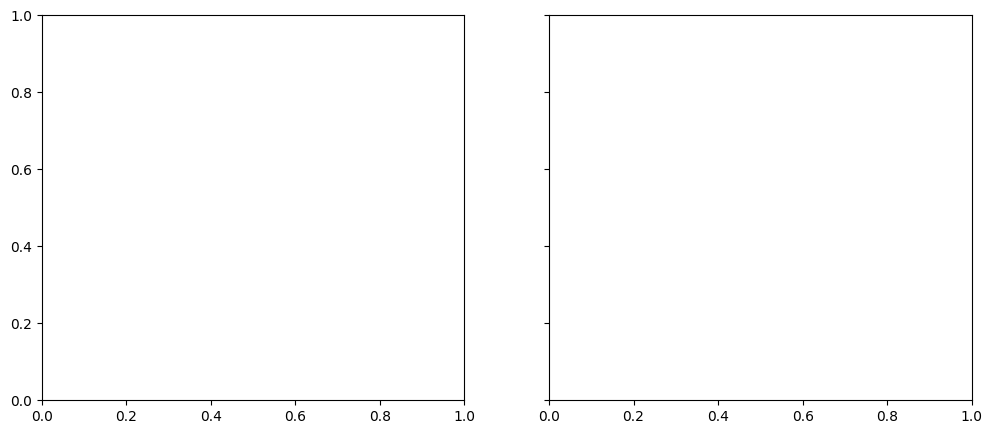

In [19]:
# transform visual_stimulus_lowest_binned to a numeric value for plotting
df_test['visual_stimulus_lowest_binned_num'] = pd.to_numeric(df_test['visual_stimulus_lowest_binned'], errors='coerce')

# make two plots, one for when the animals comes from the left and one for when it comes from the right
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Plot for when the animal comes from the left
for ax, side in zip(axs.ravel(), ['left', 'right']):
    df_side = df_test[df_test['previous_port_before_stimulus'] == side]
    for i in df_side.groupby('visual_stimulus_ratio'):
        df_i = i[1].sort_values(by='visual_stimulus_lowest_binned_num')
        # drop nan
        df_i = df_i.dropna(subset=['visual_stimulus_lowest_binned_num'])
        X = df_i['visual_stimulus_lowest_binned_num'].values.reshape(-1, 1)
        y = df_i['left_choice'].values.astype(int)
        model = LogisticRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1]
        ax.plot(X, y_prob, label=f"Visual Stimulus ratio: {i[0]}")
    ax.set_xlabel("Absolute Value of Lowest Visual Stimulus")
    ax.set_ylabel("Probability of Left Choice")
    ax.legend()
    ax.set_title(f"Last Choice Before Stimulus: {side.capitalize()}")
plt.show()

Fit the lapse model independently considering previous choices

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

colors = ["blue", "orange"]

for color, side in zip(colors, ['left', 'right']):
    df_side = df_test[df_test['previous_port_before_stimulus'] == side]
    # Fit the model
    x = df_side['visual_stimulus_ratio'].values
    y = df_side['left_choice'].values
    result = minimize(
        lapse_logistic_independent,
        initial_params,
        args=(x, y),
        bounds=[(0, 0.5), (0, 0.5), (None, None), (None, None)]
    )

    # Extract fitted parameters
    lapse_left, lapse_right, beta, x0 = result.x
    print(f"Side: {side}, Lapse Left: {lapse_left}, Lapse Right: {lapse_right}, Slope (Beta): {beta}, PSE (x0): {x0}")

    # Generate predictions
    xs = np.linspace(df_side['visual_stimulus_ratio'].min(), df_side['visual_stimulus_ratio'].max(), 100)
    p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (xs - x0)))

    # Plot the fitted curve

    sns.pointplot(
        x='visual_stimulus_ratio',
        y='left_choice',
        data=df_side,
        estimator=lambda x: np.mean(x),
        color=color,
        markers='o',
        errorbar=("ci", 95),
        ax=ax,
        label=f'Choices when coming from {side}',
        native_scale=True,
        linestyles='',
    )
    ax.plot(xs, p_left, color=color, label='Lapse Logistic Fit')
    ax.set_xlabel("Visual Stimulus ratio")
    ax.set_ylabel("Probability of Left Choice")
    plt.title(f"Psychometric Curves")
    ax.legend()
plt.show()

I kept what you did for comparison here

In [ ]:
# It is interesting to compare the effects of the relative difference between the two visual stimuli,
# and the absolute difference between them.

# Maybe what we can do is to train another logistic regression model, adding as well the absolute difference
# between the two visual stimuli, and see how it affects the probability of a left choice.
# Do you know what I mean?

for i in df_test.groupby('visual_stimulus_ratio'):
    df_i = i[1].sort_values(by='visual_stimulus_diff')
    X = df_i['visual_stimulus_diff'].values.reshape(-1, 1)
    y = df_i['left_choice'].values.astype(int)
    model = LogisticRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    plt.plot(X, y_prob, label=f"Visual Stimulus ratio: {i[0]}")
    plt.legend()
plt.xlabel("Visual Stimulus Difference")
plt.ylabel("Probability of Left Choice")
plt.show()

Multiple animals analysis


In [ ]:
df_dic = {}
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_session_data(
        project_name=tv_projects[1],
        animal=mouse,
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )
    # load the data
    df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

In [ ]:
df_dic_hard = {}
for df_name, df in zip(df_dic.keys(), df_dic.values()):
    if 'TwoAFC_visual_hard' in df["current_training_stage"].unique():
        df = df.dropna(subset = ['visual_stimulus'])
        df = df[df["current_training_stage"] == "TwoAFC_visual_hard"]

        df['visual_stimulus_ratio'] = df['visual_stimulus'].apply(lambda x: abs(round(eval(x)[0] / eval(x)[1], 4)))
        df['visual_stimulus_ratio'] = df.apply(
            lambda row: row['visual_stimulus_ratio'] if row['correct_side'] == 'left' else -row['visual_stimulus_ratio'],
            axis=1
        )
        df['visual_stimulus_diff'] = df['visual_stimulus'].apply(lambda x: abs(eval(x)[0] - eval(x)[1]))
        df['visual_stimulus_diff'] = df.apply(
            lambda row: row['visual_stimulus_diff'] if row['correct_side'] == 'left' else -row['visual_stimulus_diff'],
            axis=1
        )
        df["visual_stimulus_diff_binned"] = df['visual_stimulus_diff'] // 0.1
        df = dft.add_mouse_first_choice(df)
        df['left_choice'] = df['first_choice'].apply(lambda x: 1 if x == 'left' else 0)
        
        df_dic_hard[df_name] = df

In [ ]:
df_ratio_diffBin_inter_p = pd.DataFrame()
df_ratio_diffBin_inter_coef = pd.DataFrame()
for df_name, df in zip(df_dic_hard.keys(), df_dic_hard.values()):
    df_hard_fit = df.copy(deep=True)
    df_hard_fit = dft.parameters_for_fit(df_hard_fit)
    df_dic_hard_fit[df_name] = df_hard_fit


In [ ]:
df_dic_hard_fit_firHalf = {}
for df_name, df in zip(df_dic_hard_fit.keys(), df_dic_hard_fit.values()):
    df_hard_fit_firHalf = df[:(len(df)//2)]
    df_dic_hard_fit_firHalf[df_name] = df_hard_fit_firHalf

In [ ]:
df_dic_hard_aud = {}
for df_name, df in zip(df_dic.keys(), df_dic.values()):
    if 'TwoAFC_auditory_hard' in df["current_training_stage"].unique():
        df = df[df["current_training_stage"] == "TwoAFC_auditory_hard"]
        df = dft.get_performance_by_difficulty_ratio(df)
        df_dic_hard_aud[df_name] = df

In [ ]:
df_dic_hard_aud_fit = {}
for df_name, df in zip(df_dic_hard_aud.keys(), df_dic_hard_aud.values()):
    df_hard_aud_fit = df.copy(deep=True)
    df_hard_aud_fit = dft.parameters_for_fit(df_hard_aud_fit)
    df_dic_hard_aud_fit[df_name] = df_hard_aud_fit

In [ ]:
plt.figure(figsize=(5, 5))
for df_name, df, color in zip(df_dic_hard.keys(), df_dic_hard.values(), sns.color_palette("colorblind", len(df_dic_hard))):
    plots.psychometric_plot(df, x='visual_stimulus_ratio', y='first_choice_numeric', point_kwargs={'color': color, 'label' : ''}, line_kwargs={'color': color, 'label': df_name})
plt.show()

In [ ]:
plt.figure(figsize=(5, 5))
for df_name, df, color in zip(df_dic_hard_aud.keys(), df_dic_hard_aud.values(), sns.color_palette("colorblind", len(df_dic_hard_aud))):
    plots.psychometric_plot(df, x='total_evidence_strength', y='first_choice_numeric', valueType = 'continue', point_kwargs={'color': color, 'label' : ''}, line_kwargs={'color': color, 'label': df_name})
plt.show()

In [ ]:
X = ['visual_stimulus_ratio',
    'visual_ratio_diff_interact',
    'visual_ratio_bright_interact', 
    'previous_left_choice_correct_numeric',
    'previous_right_choice_wrong_numeric',
    'previous_first_choice_numeric', 
    'previous_last_choice_numeric', 
    'previous_port_before_stimulus_numeric',
    # 'time_kernel_impact'
        ]
y = 'first_choice_numeric'
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for var, n in zip(X, range(len(X))):
    row = n // 5
    col = n % 5
    for df_name, df, color in zip(df_dic_hard_fit.keys(), df_dic_hard_fit.values(), sns.color_palette("colorblind", len(df_dic_hard_fit))):
        df_new = df.dropna(subset=[var, y]) 
        # Check if the variable in daraframe is discrete or continuous
        if df_new[var].nunique() < 10:
            # If discrete, plot as discrete
            plots.psychometric_plot(df = df_new,
                                x = var, 
                                y = y, 
                                ax = ax[row][col],
                                point_kwargs={'color': color, 'label': ''},
                                line_kwargs={'color': color, 'label': df_name}, 
                                valueType='discrete'
                                        )
        else:
            # If continuous, plot as continuous
            plots.psychometric_plot(df = df_new,
                                x = var, 
                                y = y, 
                                ax = ax[row][col],
                                point_kwargs={'color': color, 'label': ''},
                                line_kwargs={'color': color, 'label': df_name}, 
                                valueType='continue'
                                        )

find the optimal parameters of time kernel

In [ ]:
comb_dict = utils.verify_params_time_kernel(dic = df_dic_hard, y='first_choice_numeric')
sorted_items = sorted(comb_dict.items(), key=lambda item: abs(item[1]), reverse=True)
sorted_items[:5]

filter the correlated values

In [ ]:
X = ['visual_stimulus_ratio',
    'visual_ratio_diff_interact',
    'visual_ratio_bright_interact', 
    # 'previous_left_choice_correct_numeric',
    # 'previous_right_choice_wrong_numeric',
    # 'previous_first_choice_numeric', 
    # 'previous_last_choice_numeric', 
    # 'previous_port_before_stimulus_numeric',
    # 'time_kernel_impact'
        ]
corr_mat_list, norm_contribution_df = utils.filter_variables_for_model(dic_fit=df_dic_hard_fit_firHalf, X = X, y='first_choice_numeric', max_lag=19, tau=1)
plots.plot_filter_model_variables(corr_mat_list=corr_mat_list, norm_contribution_df=norm_contribution_df)

fit the model by filtered variables

In [ ]:

X = ['visual_stimulus_ratio',
    'previous_port_before_stimulus_numeric',
    'visual_ratio_diff_interact',
    'previous_left_choice_correct_numeric',
    # 'previous_right_choice_wrong_numeric',
    # 'previous_first_choice_numeric', 
    'visual_ratio_bright_interact', 
    # 'previous_last_choice_numeric', 
    'time_kernel_impact'
        ]
df_leftChoice_model_p = pd.DataFrame()
df_leftChoice_model_coef = pd.DataFrame()
df_leftChoice_model_z =  pd.DataFrame()
for df_name, df, color in zip(df_dic_hard_fit_firHalf.keys(), df_dic_hard_fit_firHalf.values(), sns.color_palette("colorblind", len(df_dic_hard_fit_firHalf))):
    df_for_fit = dft.parameters_for_fit(df)
    df_for_fit = dft.get_time_kernel_impact(df_for_fit, y='first_choice_numeric', max_lag=19, tau=1)
    _, model = utils.logi_model_fit(df_for_fit, X=X, y='first_choice_numeric')
    # plot the results
    df_leftChoice_model_p[df_name] = model.pvalues
    df_leftChoice_model_coef[df_name] = model.params
    df_leftChoice_model_z[df_name] = model.tvalues


compare the parameters of model by p, coef, z directly

In [ ]:
# plot the p-values coefficients and z
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
df_leftChoice_model_p.index = ['intercept'] + X
df_leftChoice_model_coef.index = ['intercept'] + X
df_leftChoice_model_z.index = ['intercept'] + X
df_leftChoice_model_p_long = df_leftChoice_model_p.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_leftChoice_model_p_long, x='index', y='Value', ax=ax[0], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_leftChoice_model_p_long, ax=ax[0], x='index', y='Value', hue='Mouse', palette='colorblind')
ax[0].axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
df_leftChoice_model_coef_long = df_leftChoice_model_coef.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_leftChoice_model_coef_long, x='index', y='Value', ax=ax[1], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_leftChoice_model_coef_long, ax=ax[1], x='index', y='Value', hue='Mouse', palette='colorblind')
df_leftChoice_model_z_long = df_leftChoice_model_z.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_leftChoice_model_z_long, x='index', y='Value', ax=ax[2], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_leftChoice_model_z_long, ax=ax[2], x='index', y='Value', hue='Mouse', palette='colorblind')
# make x label not overlapping
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=8, ha='right')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=8, ha='right')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=8, ha='right')
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")
ax[0].set_ylabel("P-values")
ax[1].set_ylabel("Coefficients")
ax[2].set_ylabel("Z-scores")
plt.tight_layout()
plt.show()

correct choice model

In [ ]:
comb_dict = utils.verify_params_time_kernel(dic = df_dic_hard, y='correct_numeric')
sorted_items = sorted(comb_dict.items(), key=lambda item: abs(item[1]), reverse=True)
sorted_items[:5]

In [ ]:
X = ['abs_visual_stimulus_ratio',
    'wrong_bright', 
    'previous_same_choice_correct_numeric', 
    'previous_same_choice_numeric', 
    'previous_correct_numeric', 
    'previous_port_before_stimulus_numeric', 
    'previous_first_choice_numeric', 
    'previous_last_choice_numeric', 
    'time_kernel_impact'
        ]
corr_mat_list, norm_contribution_df = utils.filter_variables_for_model(dic_fit=df_dic_hard_fit_firHalf, X = X, y='correct_numeric', max_lag=19, tau=7)
plots.plot_filter_model_variables(corr_mat_list=corr_mat_list, norm_contribution_df=norm_contribution_df)

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [ ]:
def drop_one_var_contribution(df, x_cols, y_col, method='newton'):
    contributions = {var: [] for var in x_cols}
    X, y = utils.logi_model_fit_input(df, x_cols, y_col)
    model = sm.Logit(y, X).fit(method=method)
    r2 = r2_score(y, model.predict(X))
    for var in x_cols:
        X_reduced = X.drop(columns=[var])
        model_reduced = sm.Logit(y, X_reduced).fit(method=method)
        r2_reduced = r2_score(y, model_reduced.predict(X_reduced))
        delta = r2 - r2_reduced
        contributions[var].append(delta)
    # normalize the contributions
    avg_contrib = {var: np.mean(contrib) for var, contrib in contributions.items()}
    total = sum(avg_contrib.values())
    norm_contrib = {var: val / total for var, val in avg_contrib.items()}
    return pd.Series(norm_contrib)

In [ ]:
def filter_variables_for_model_2(dic_fit:dict, X:list, y:str, max_lag=None, tau=None):
    corr_mat_list = []
    norm_contribution_df = pd.DataFrame([])
    for df_name, df_for_fit in zip(dic_fit.keys(), dic_fit.values()):
        if (max_lag is not None) & (tau is not None):
            df_for_fit = dft.get_time_kernel_impact(df_for_fit, y=y, max_lag=max_lag, tau=tau)
        
        corr_fit_X_df = df_for_fit[X].corr()
        corr_mat_list.append(corr_fit_X_df)

        norm_contribution = drop_one_var_contribution(df_for_fit, x_cols = X, y_col = y, method='bfgs')
        norm_contribution_df[df_name] = norm_contribution

    return corr_mat_list, norm_contribution_df

In [ ]:
X = ['abs_visual_stimulus_ratio',
    'wrong_bright', 
    'previous_same_choice_correct_numeric', 
    'previous_same_choice_numeric', 
    'previous_correct_numeric', 
    'previous_port_before_stimulus_numeric', 
    'previous_first_choice_numeric', 
    'previous_last_choice_numeric', 
    'time_kernel_impact'
        ]
corr_mat_list, norm_contribution_df = filter_variables_for_model_2(dic_fit=df_dic_hard_fit_firHalf, X = X, y='correct_numeric', max_lag=19, tau=7)

plots.plot_filter_model_variables(corr_mat_list=corr_mat_list, norm_contribution_df=norm_contribution_df)

In [ ]:
X = ['abs_visual_stimulus_ratio',
    'wrong_bright', 
    'previous_same_choice_correct_numeric', 
    'previous_same_choice_numeric', 
    'previous_correct_numeric', 
    # 'previous_port_before_stimulus_numeric', 
    # 'previous_first_choice_numeric', 
    # 'previous_last_choice_numeric', 
    'time_kernel_impact'
        ]
corr_mat_list, norm_contribution_df = filter_variables_for_model_2(dic_fit=df_dic_hard_fit_firHalf, X = X, y='correct_numeric', max_lag=19, tau=7)

plots.plot_filter_model_variables(corr_mat_list=corr_mat_list, norm_contribution_df=norm_contribution_df)

In [ ]:
X = ['visual_stimulus_ratio',
    'wrong_bright', 
    'previous_same_choice_correct_numeric', 
    'previous_same_choice_numeric', 
    'previous_correct_numeric', 
    # 'previous_port_before_stimulus_numeric', 
    # 'previous_first_choice_numeric', 
    'previous_last_choice_numeric', 
    'time_kernel_impact'
    ]
df_correctChoice_model_p = pd.DataFrame()
df_correctChoice_model_coef = pd.DataFrame()
df_correctChoice_model_z =  pd.DataFrame()
for df_name, df, color in zip(df_dic_hard_fit_firHalf.keys(), df_dic_hard_fit_firHalf.values(), sns.color_palette("colorblind", len(df_dic_hard_fit_firHalf))):
    df_for_fit = dft.parameters_for_fit(df)
    df_for_fit = dft.get_time_kernel_impact(df_for_fit, y='correct_numeric', max_lag=19, tau=7)
    _, model = utils.logi_model_fit(df_for_fit, X=X, y='correct_numeric')
    # plot the results
    df_correctChoice_model_p[df_name] = model.pvalues
    df_correctChoice_model_coef[df_name] = model.params
    df_correctChoice_model_z[df_name] = model.tvalues

In [ ]:
# plot the p-values coefficients and z
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
df_correctChoice_model_p.index = ['intercept'] + X
df_correctChoice_model_coef.index = ['intercept'] + X
df_correctChoice_model_z.index = ['intercept'] + X
df_correctChoice_model_p_long = df_correctChoice_model_p.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_correctChoice_model_p_long, x='index', y='Value', ax=ax[0], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_correctChoice_model_p_long, ax=ax[0], x='index', y='Value', hue='Mouse', palette='colorblind')
ax[0].axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
df_correctChoice_model_coef_long = df_correctChoice_model_coef.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_correctChoice_model_coef_long, x='index', y='Value', ax=ax[1], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_correctChoice_model_coef_long, ax=ax[1], x='index', y='Value', hue='Mouse', palette='colorblind')
df_correctChoice_model_z_long = df_correctChoice_model_z.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_correctChoice_model_z_long, x='index', y='Value', ax=ax[2], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_correctChoice_model_z_long, ax=ax[2], x='index', y='Value', hue='Mouse', palette='colorblind')
# make x label not overlapping
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=8, ha='right')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=8, ha='right')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=8, ha='right')
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")
ax[0].set_ylabel("P-values")
ax[1].set_ylabel("Coefficients")
ax[2].set_ylabel("Z-scores")
plt.tight_layout()
plt.show()

timebin evidence

In [ ]:
timebin_evidence_df = pd.DataFrame()
for df_name, df, color in zip(df_dic_hard_aud_fit.keys(), df_dic_hard_aud_fit.values(), sns.color_palette("colorblind", len(df_dic_hard_aud_fit))):
    X = np.array([utils.get_timebin_evidence(eval(t)) for t in df['auditory_stimulus']])
    y = df['first_choice_numeric']
    X_model = sm.add_constant(X) 
    glm = sm.Logit(y, X_model).fit()
    timebin_evidence_df[df_name] = glm.params[1:]

In [ ]:
fig = plt.figure(figsize=(12, 5))
timebin_evidence_df.index = range(len(timebin_evidence_df))
for df_name, col, color in zip(timebin_evidence_df.columns, timebin_evidence_df, sns.color_palette("colorblind", len(timebin_evidence_df))):
    plt.plot(timebin_evidence_df[col], color=color, label=df_name, linestyle='--', alpha=0.7)
plt.plot(timebin_evidence_df.mean(axis=1), color='black', label='Mean Coefficient', linewidth=2)
plt.xlabel("Time Bin")
plt.ylabel("Coefficient")
plt.title("Time Bin Evidence Coefficients for Left Choice")
plt.legend()

In [ ]:
timebin_evidence_df = pd.DataFrame()
for df_name, df, color in zip(df_dic_hard_aud_fit.keys(), df_dic_hard_aud_fit.values(), sns.color_palette("colorblind", len(df_dic_hard_aud_fit))):
    X = np.abs(np.array([utils.get_timebin_evidence(eval(t)) for t in df['auditory_stimulus']]))
    y = df['correct_numeric']
    X_model = sm.add_constant(X) 
    glm = sm.Logit(y, X_model).fit()
    timebin_evidence_df[df_name] = glm.params[1:]

In [ ]:
fig = plt.figure(figsize=(12, 5))
timebin_evidence_df.index = range(len(timebin_evidence_df))
for df_name, col, color in zip(timebin_evidence_df.columns, timebin_evidence_df, sns.color_palette("colorblind", len(timebin_evidence_df))):
    plt.plot(timebin_evidence_df[col], color=color, label=df_name, linestyle='--', alpha=0.7)
plt.plot(timebin_evidence_df.mean(axis=1), color='black', label='Mean Coefficient', linewidth=2)
plt.xlabel("Time Bin")
plt.ylabel("Coefficient")
plt.title("Time Bin Evidence Coefficients for Correct Choice")
plt.legend()

In [ ]:
comb_dict = utils.verify_params_time_kernel(dic = df_dic_hard_aud, y='first_choice_numeric')
sorted_items = sorted(comb_dict.items(), key=lambda item: abs(item[1]), reverse=True)
sorted_items[:5]

In [ ]:
X = ['total_percentage_of_tones_left',
    'number_of_tones_left',
    'percentage_of_timebins_with_evidence_left', 
    'total_evidence_strength', 
    'amplitude_strength',
    'previous_port_before_stimulus_numeric',
    'previous_left_choice_correct_numeric',
    'previous_right_choice_wrong_numeric',
    'previous_first_choice_numeric', 
    'previous_last_choice_numeric', 
    'time_kernel_impact'
        ]
corr_mat_list, norm_contribution_df = utils.filter_variables_for_model(dic=df_dic_hard_aud, X = X, y='first_choice_numeric', max_lag=2, tau=1)
plots.plot_filter_model_variables(corr_mat_list=corr_mat_list, norm_contribution_df=norm_contribution_df)

In [ ]:
X = [
    # 'total_percentage_of_tones_left',
    # 'number_of_tones_left',
    # 'percentage_of_timebins_with_evidence_left', 
    'total_evidence_strength', 
    'amplitude_strength',
    'previous_port_before_stimulus_numeric',
    # 'previous_left_choice_correct_numeric',
    'previous_right_choice_wrong_numeric',
    'previous_first_choice_numeric', 
    'previous_last_choice_numeric', 
    # 'time_kernel_impact'
    ]
df_leftChoice_model_aud_p = pd.DataFrame()
df_leftChoice_model_aud_coef = pd.DataFrame()
df_leftChoice_model_aud_z =  pd.DataFrame()
for df_name, df, color in zip(df_dic_hard_aud.keys(), df_dic_hard_aud.values(), sns.color_palette("colorblind", len(df_dic_hard_aud))):
    df_for_fit = dft.parameters_for_fit(df)
    df_for_fit = dft.get_time_kernel_impact(df_for_fit, y='first_choice_numeric', max_lag=2, tau=1)
    _, model = utils.logi_model_fit(df_for_fit, X=X, y='first_choice_numeric')
    # plot the results
    df_leftChoice_model_aud_p[df_name] = model.pvalues
    df_leftChoice_model_aud_coef[df_name] = model.params
    df_leftChoice_model_aud_z[df_name] = model.tvalues

In [ ]:
# plot the p-values coefficients and z
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
df_leftChoice_model_aud_p.index = ['intercept'] + X
df_leftChoice_model_aud_coef.index = ['intercept'] + X
df_leftChoice_model_aud_z.index = ['intercept'] + X
df_leftChoice_model_aud_p_long = df_leftChoice_model_aud_p.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_leftChoice_model_aud_p_long, x='index', y='Value', ax=ax[0], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_leftChoice_model_aud_p_long, ax=ax[0], x='index', y='Value', hue='Mouse', palette='colorblind')
ax[0].axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
df_leftChoice_model_aud_coef_long = df_leftChoice_model_aud_coef.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_leftChoice_model_aud_coef_long, x='index', y='Value', ax=ax[1], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_leftChoice_model_aud_coef_long, ax=ax[1], x='index', y='Value', hue='Mouse', palette='colorblind')
df_leftChoice_model_aud_z_long = df_leftChoice_model_aud_z.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_leftChoice_model_aud_z_long, x='index', y='Value', ax=ax[2], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_leftChoice_model_aud_z_long, ax=ax[2], x='index', y='Value', hue='Mouse', palette='colorblind')
# make x label not overlapping
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=8, ha='right')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=8, ha='right')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=8, ha='right')
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")
ax[0].set_ylabel("P-values")
ax[1].set_ylabel("Coefficients")
ax[2].set_ylabel("Z-scores")
plt.tight_layout()
plt.show()

model for auditory stimulus

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for df_name, df, n in zip(df_dic_hard.keys(), df_dic_hard.values(), range(len(df_dic_hard))):
    row = n // 5
    col = n % 5
    for session, color in zip(df['session'].unique(), sns.color_palette("crest", len(df['session'].unique()))):
        df_session = df[df['session'] == session]
        plots.psychometric_plot(df_session, x='visual_stimulus_ratio', y='left_choice',ax=ax[row, col], point_kwargs={'color': color, 'label' : ''}, line_kwargs={'color': color, 'label': ''})
    ax[row, col].set_title(f"Psychometric Curve for {df_name}")
plt.tight_layout()
# Add a colorbar to indicate the session
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("crest", as_cmap=True)), orientation='horizontal', ax=ax, shrink=0.3)
cbar.set_ticks([])
cbar.set_label('before → after')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for df_name, df, color in zip(df_dic_hard.keys(), df_dic_hard.values(), sns.color_palette("colorblind", len(df_dic_hard))):
    # divide into different groups with 1000 trials
    df['trial_group'] = np.arange(len(df)) // 1000
    lapse_left = []
    lapse_right = []
    slope = []
    bias = []
    for group in df['trial_group'].unique():
        df_group = df[df['trial_group'] == group]
        pleft, params = utils.fit_lapse_logistic_independent(df_group['visual_stimulus_diff'], df_group['left_choice'])
        # params in fit_lapse_logistic_independent = (lapse_left, lapse_right, beta, x0)
        lapse_left.append(params[0])
        lapse_right.append(params[1])
        slope.append(params[2])
        bias.append(params[3])
    ax[0, 0].plot(lapse_left, c=color, label=df_name)
    ax[0, 1].plot(lapse_right, c=color, label=df_name)
    ax[1, 0].plot(slope, c=color, label=df_name)
    ax[1, 1].plot(bias, c=color, label=df_name)
ax[0, 0].set_ylabel("Lapse Left")
ax[0, 1].set_ylabel("Lapse Right")
ax[1, 0].set_ylabel("slope")
ax[1, 1].set_ylabel("bias")
for ax1 in ax.flat:
    ax1.set_xlabel('1000_trials')
    ax1.legend()
plt.suptitle("Model for left choice on visual stimulus ratio")
plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for df_name, df, color in zip(df_dic_hard_aud.keys(), df_dic_hard_aud.values(), sns.color_palette("colorblind", len(df_dic_hard_aud))):
    # divide into different groups with 1000 trials
    df['trial_group'] = np.arange(len(df)) // 1000
    lapse_left = []
    lapse_right = []
    slope = []
    bias = []
    for group in df['trial_group'].unique():
        df_group = df[df['trial_group'] == group]
        pleft, params = utils.fit_lapse_logistic_independent(df_group['total_evidence_strength'], df_group['first_choice_numeric'])
        # params in fit_lapse_logistic_independent = (lapse_left, lapse_right, beta, x0)
        lapse_left.append(params[0])
        lapse_right.append(params[1])
        slope.append(params[2])
        bias.append(params[3])
    ax[0, 0].plot(lapse_left, c=color, label=df_name)
    ax[0, 1].plot(lapse_right, c=color, label=df_name)
    ax[1, 0].plot(slope, c=color, label=df_name)
    ax[1, 1].plot(bias, c=color, label=df_name)
ax[0, 0].set_ylabel("Lapse Left")
ax[0, 1].set_ylabel("Lapse Right")
ax[1, 0].set_ylabel("slope")
ax[1, 1].set_ylabel("bias")
for ax1 in ax.flat:
    ax1.set_xlabel('1000_trials')
    ax1.legend()
plt.suptitle("Model for left choice on auditory evidence strenth")
plt.tight_layout()
plt.show()


In [ ]:
X = ['visual_stimulus_ratio',
    'previous_port_before_stimulus_numeric',
    'visual_ratio_diff_interact',
    'previous_left_choice_correct_numeric',
    'previous_right_choice_wrong_numeric',
    'previous_first_choice_numeric', 
    'visual_ratio_bright_interact', 
    'previous_last_choice_numeric'
        ]
dic_leftChoice_model_p = {}
dic_leftChoice_model_coef = {}
dic_leftChoice_model_z = {}
for df_name, df, n in zip(df_dic_hard.keys(), df_dic_hard.values(), range(len(df_dic_hard))):
    df_leftChoice_model_p = pd.DataFrame()
    df_leftChoice_model_coef = pd.DataFrame()
    df_leftChoice_model_z =  pd.DataFrame()
    # create a session group column
    unique_sessions = df['session'].unique()
    session_to_group = {session: i // 10 for i, session in enumerate(unique_sessions)} # this groups sessions in groups of 10
    df['session_group'] = df['session'].map(session_to_group)
    for session, color in zip(df['session_group'].unique(), sns.color_palette("crest", len(df['session'].unique()))):
        df_session = df[df['session_group'] == session]
        df_session_for_fit = dft.parameters_for_fit(df_session)
        # # normalize the X columns in the df_session_for_fit by zscore
        # df_session_for_fit[X] = df_session_for_fit[X].apply(lambda x: (x - x.mean()) / x.std())
        _, model = utils.logi_model_fit(df_session_for_fit, X=X, y='first_choice_numeric', method='powell')
        df_leftChoice_model_p[session] = model.pvalues
        df_leftChoice_model_coef[session] = model.params
        df_leftChoice_model_z[session] = model.tvalues
    df_leftChoice_model_p.index = ['intercept'] + X
    df_leftChoice_model_coef.index = ['intercept'] + X
    df_leftChoice_model_z.index = ['intercept'] + X
    dic_leftChoice_model_p[df_name] = df_leftChoice_model_p.T
    dic_leftChoice_model_coef[df_name] = df_leftChoice_model_coef.T
    dic_leftChoice_model_z[df_name] = df_leftChoice_model_z.T

In [ ]:
fig, ax = plt.subplots(3, len(X)+1, figsize=(30, 15))
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_leftChoice_model_p, sns.color_palette("colorblind", len(dic_leftChoice_model_p))):
        ax[0, n].plot(dic_leftChoice_model_p[mouse].index, dic_leftChoice_model_p[mouse].iloc[:, n], label=mouse, color=color)
    ax[0, n].set_title(param)
    ax[0, n].set_xlabel("10_Session")
    ax[0, n].set_ylabel("p-value")
    ax[0, n].axhline(y=0.05, color='red', linestyle='--', label='Significance 0.05')
    ax[0, n].legend()
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_leftChoice_model_coef, sns.color_palette("colorblind", len(dic_leftChoice_model_coef))):
        ax[1, n].plot(dic_leftChoice_model_coef[mouse].index, dic_leftChoice_model_coef[mouse].iloc[:, n], label=mouse, color=color)
    ax[1, n].set_title(param)
    ax[1, n].set_xlabel("10_Session")
    ax[1, n].set_ylabel("Coefficient")
    ax[1, n].legend()
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_leftChoice_model_z, sns.color_palette("colorblind", len(dic_leftChoice_model_z))):
        ax[2, n].plot(dic_leftChoice_model_z[mouse].index, dic_leftChoice_model_z[mouse].iloc[:, n], label=mouse, color=color)
    ax[2, n].set_title(param)
    ax[2, n].set_xlabel("10_Session")
    ax[2, n].set_ylabel("Z-score")
    ax[2, n].legend()

In [ ]:
X = ['visual_stimulus_ratio',
    'wrong_bright', 
    # 'wrong_bright_zscore',
    'previous_same_choice_correct_numeric', 
    # 'previous_diff_choice_wrong_numeric', 
    'previous_same_choice_numeric', 
    'previous_correct_numeric'
    'roa_choice_numeric'
    ]
dic_correctChoice_model_p = {}
dic_correctChoice_model_coef = {}
dic_correctChoice_model_z = {}
for df_name, df, n in zip(df_dic_hard.keys(), df_dic_hard.values(), range(len(df_dic_hard))):
    row = n // 5
    col = n % 5
    df_correctChoice_model_p = pd.DataFrame()
    df_correctChoice_model_coef = pd.DataFrame()
    df_correctChoice_model_z =  pd.DataFrame()
    # create a session group column
    unique_sessions = df['session'].unique()
    session_to_group = {session: i // 10 for i, session in enumerate(unique_sessions)} # this groups sessions in groups of 10
    df['session_group'] = df['session'].map(session_to_group)
    for session, color in zip(df['session_group'].unique(), sns.color_palette("crest", len(df['session'].unique()))):
        df_session = df[df['session_group'] == session]
        df_session_for_fit = dft.parameters_for_fit(df_session)
        # # normalize the X columns in the df_session_for_fit by zscore
        # df_session_for_fit[X] = df_session_for_fit[X].apply(lambda x: (x - x.mean()) / x.std())
        _, model = utils.logi_model_fit(df_session_for_fit, X=X, y='correct_numeric', method='powell')
        df_correctChoice_model_p[session] = model.pvalues
        df_correctChoice_model_coef[session] = model.params
        df_correctChoice_model_z[session] = model.tvalues
    df_correctChoice_model_p.index = ['intercept'] + X
    df_correctChoice_model_coef.index = ['intercept'] + X
    df_correctChoice_model_z.index = ['intercept'] + X
    dic_correctChoice_model_p[df_name] = df_correctChoice_model_p.T
    dic_correctChoice_model_coef[df_name] = df_correctChoice_model_coef.T
    dic_correctChoice_model_z[df_name] = df_correctChoice_model_z.T

In [ ]:
fig, ax = plt.subplots(3, len(X)+1, figsize=(30, 15))
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_correctChoice_model_p, sns.color_palette("colorblind", len(dic_correctChoice_model_p))):
        ax[0, n].plot(dic_correctChoice_model_p[mouse].index, dic_correctChoice_model_p[mouse].iloc[:, n], label=mouse, color=color)
    ax[0, n].set_title(param)
    ax[0, n].set_xlabel("10_Session")
    ax[0, n].set_ylabel("p-value")
    ax[0, n].axhline(y=0.05, color='red', linestyle='--', label='Significance 0.05')
    ax[0, n].legend()
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_correctChoice_model_coef, sns.color_palette("colorblind", len(dic_correctChoice_model_coef))):
        ax[1, n].plot(dic_correctChoice_model_coef[mouse].index, dic_correctChoice_model_coef[mouse].iloc[:, n], label=mouse, color=color)
    ax[1, n].set_title(param)
    ax[1, n].set_xlabel("10_Session")
    ax[1, n].set_ylabel("Coefficient")
    ax[1, n].legend()
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_correctChoice_model_z, sns.color_palette("colorblind", len(dic_correctChoice_model_z))):
        ax[2, n].plot(dic_correctChoice_model_z[mouse].index, dic_correctChoice_model_z[mouse].iloc[:, n], label=mouse, color=color)
    ax[2, n].set_title(param)
    ax[2, n].set_xlabel("10_Session")
    ax[2, n].set_ylabel("Z-score")
    ax[2, n].legend()